Link to dataset is below


https://www.kaggle.com/c/fake-news/data

importing important libraries

In [1]:
import numpy as np
import re
import string
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from nltk.corpus import stopwords

function to clean text by preprocessing

In [2]:
def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)

In [3]:
def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

In [4]:
def constructLabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [5]:
def getEmbeddings(path,vector_dimension=300):
    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    x = constructLabeledSentences(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    text_train_arrays = np.zeros((train_size, vector_dimension))
    text_test_arrays = np.zeros((test_size, vector_dimension))
    train_labels = np.zeros(train_size)
    test_labels = np.zeros(test_size)

    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
        train_labels[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
        test_labels[j] = y[i]
        j = j + 1

    return text_train_arrays, text_test_arrays, train_labels, test_labels

In [6]:
def clean_data():
    path = 'datasets/train.csv'
    vector_dimension=300

    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    data = data.sample(frac=1).reset_index(drop=True)

    x = data.loc[:,'text'].values
    y = data.loc[:,'label'].values

    train_size = int(0.8 * len(y))
    test_size = len(x) - train_size

    xtr = x[:train_size]
    xte = x[train_size:]
    ytr = y[:train_size]
    yte = y[train_size:]

    np.save('xtr_shuffled.npy',xtr)
    np.save('xte_shuffled.npy',xte)
    np.save('ytr_shuffled.npy',ytr)
    np.save('yte_shuffled.npy',yte)

naive-bayes


In [7]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

In [8]:
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred)
    plt.show()

In [9]:
import nltk
nltk.download('stopwords')
xtr,xte,ytr,yte = getEmbeddings("datasets/train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MAYANK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\MAYANK\3D Objects\x\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.
C:\Users\MAYANK\3D Objects\x\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [10]:
gnb = GaussianNB()
gnb.fit(xtr,ytr)
y_pred = gnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%") 

Accuracy = 72.24%


C:\Users\MAYANK\3D Objects\x\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


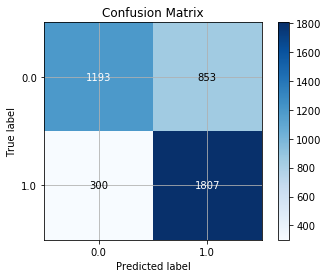

In [11]:
plot_cmat(yte, y_pred)

neural-net-keras

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt

Using TensorFlow backend.


In [13]:
xtr,xte,ytr,yte = getEmbeddings("datasets/train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

C:\Users\MAYANK\3D Objects\x\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.
C:\Users\MAYANK\3D Objects\x\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [14]:
def baseline_model():
    '''Neural network with 3 hidden layers'''
    model = Sequential()
    model.add(Dense(256, input_dim=300, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu', kernel_initializer='normal'))
    model.add(Dense(2, activation="softmax", kernel_initializer='normal'))

    # gradient descent
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    # configure the learning process of the model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [15]:
model = baseline_model()
model.summary()
x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y = np_utils.to_categorical((label_encoder.transform(y_train)))
label_encoder.fit(y_test)
encoded_y_test = np_utils.to_categorical((label_encoder.transform(y_test)))
estimator = model.fit(x_train, encoded_y, epochs=10, batch_size=64)
print("Model Trained!")
score = model.evaluate(x_test, encoded_y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%") 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 162       
Total params: 163,570
Trainable params: 163,570
Non-trainable params: 0
________________________________________________

In [16]:
probabs = model.predict_proba(x_test)
y_pred = np.argmax(probabs, axis=1)

C:\Users\MAYANK\3D Objects\x\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


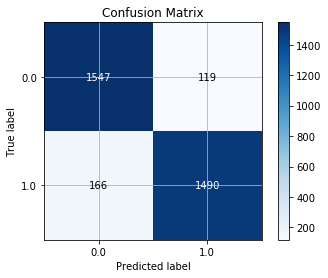

In [17]:
plot_cmat(y_test, y_pred)

svm

In [18]:
from sklearn.svm import SVC

In [19]:
xtr,xte,ytr,yte = getEmbeddings("datasets/train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

C:\Users\MAYANK\3D Objects\x\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.
C:\Users\MAYANK\3D Objects\x\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [20]:
clf = SVC()
clf.fit(xtr, ytr)
y_pred = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")

Accuracy = 91.74%


C:\Users\MAYANK\3D Objects\x\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


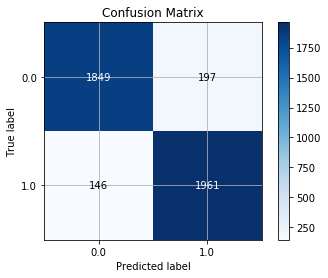

In [21]:
plot_cmat(yte, y_pred)

LSTM

In [22]:
from keras.datasets import imdb
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from collections import Counter

In [23]:
top_words = 5000
epoch_num = 5
batch_size = 64

In [24]:
if not os.path.isfile('./xtr_shuffled.npy') or \
    not os.path.isfile('./xte_shuffled.npy') or \
    not os.path.isfile('./ytr_shuffled.npy') or \
    not os.path.isfile('./yte_shuffled.npy'):
    clean_data()

In [25]:
xtr = np.load('./xtr_shuffled.npy')
xte = np.load('./xte_shuffled.npy')
y_train = np.load('./ytr_shuffled.npy')
y_test = np.load('./yte_shuffled.npy')

In [26]:
cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  

In [27]:
# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

In [28]:
# Encode the sentences
for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

In [29]:
y_train = list(y_train)
y_test = list(y_test)

In [30]:
# Delete the short news
i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

In [31]:
# Generating test data
x_test = []
for x in xte:
    x_test.append(x.split())

In [32]:
# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

In [33]:
# Truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [34]:
# Create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=batch_size)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160064    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 213,365
Trainable params: 213,365
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\MAYANK\3D Objects\x\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16048 samples, validate on 4153 samples
Epoch 1/2
16048/16048 [==============================] - 385s 24ms/step - loss: 0.3005 - accuracy: 0.8718 - val_loss: 0.2765 - val_accuracy: 0.8760
Epoch 2/2
16048/16048 [==============================] - 389s 24ms/step - loss: 0.1518 - accuracy: 0.9473 - val_loss: 0.1729 - val_accuracy: 0.9386


In [35]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

Accuracy= 93.86%


C:\Users\MAYANK\3D Objects\x\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


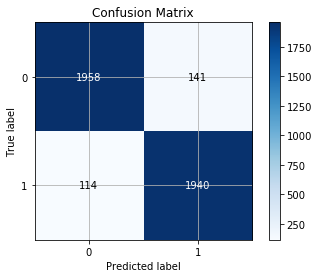

In [36]:
# Draw the confusion matrix
y_pred = model.predict_classes(X_test)
plot_cmat(y_test, y_pred)